# 1 - Project Overview and Problem Statement

## 1.1 - Domain Background

Artificial Neural Networks have rapidly growing applications in the area of image-based classification problems. Moreover, recent advances in the ANN technology allows for the use/reuse of pre-trained Deep Artificial Neural Networks (e.g. AlexNet, Resnet, VGG, and others) that were trained to recognize thousands of different categories by sifting through millions of high resolution images. This re-utilization of pretrained Deep Neural Networks belongs to a field of Machine Learning called “Transfer Learning” where these pre-built models can be repurposed to be utilized in numerous applications of image recognition and classification.

## 1.2 - Problem Statement

Recognizing the breeds of dogs is certainly a challenging task. The estimated number of known dog breeds ranges between 200 and 350 different breeds, making the task of telling “which breed a dog belongs to” a very challenging task. This task gets more difficult when the breeds are visually similar and cannot be easily distinguished.


## 1.3 - Metrics

In term of the optimization of the our models, the CrossEntropyLoss will be used to determine if a model is more suitable than another model.

Eventually, to compare the final trained model to the benchmark model, the simple metric of accuracy along with the CrossEntropyLoss are going to be used to compare the models.

Although accuracy is not necessarily the best metric to evaluate the performance of a model, it relatively sufficent here as the distribution of training/validation/testing data across the different classes (133 breeds) is not extreme. Moreover, the Cross Entropy should also serve as a secondary comparison metric between the the trained model and the benchmark model.

# 2 - Data Analysis

## 2.1 - Loading the Libraries

In [0]:
import torch
from torch import nn,optim
from torchvision import transforms,datasets,models
from torch.nn import functional as F
import os
import random
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

## 2.2 - Data Exploration

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/Dog_Breed_Classifier_with_Pytorch'
#root_path = '.'

In [0]:
data_dir = '/dogImages'
train_dir = root_path+data_dir + '/train'
valid_dir = root_path+data_dir + '/valid'
test_dir = root_path+data_dir + '/test'

In [0]:
def get_file_paths_in_directory(directory):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(directory):
        for file in f:
            files.append(os.path.join(r, file))
    files_metadata = pd.DataFrame(files)
    files_metadata.columns = ['File_path']
    return files_metadata

In [0]:
def parse_file_paths(file_paths_dataframe):
    file_paths_dataframe['path_array'] = file_paths_dataframe['File_path'].str.split("/")
    path_parts = pd.DataFrame(file_paths_dataframe['path_array'].values.tolist(), columns=['1','2','3','4','5','6','7','8'])
    return path_parts

In [0]:
def get_count_by_breed(dataset):
    dataset = dataset[['7','8']]
    dataset.columns = ['Breed','file']
    count_per_breed = dataset.groupby('Breed')['file'].count()
    count_per_breed = count_per_breed.sort_values()
    return count_per_breed

In [0]:
file_paths = get_file_paths_in_directory(root_path+data_dir)
file_parts = parse_file_paths(file_paths)

In [0]:
temp = file_parts[['6','7','8']]
temp.columns = ['dataset','breed','file']

In [24]:
temp.groupby('dataset')['file'].count().sort_values()

dataset
valid     835
test      838
train    6686
Name: file, dtype: int64

In [0]:
file_parts.to_csv('files_metadata.csv')

The training dataset we have contains 6686 images across 133 different breeds of dogs. That is, on average, 50 images per dog breed. The dataset if sufficiently large for training our model. However, we still need to look at the distribution of data across the 133 breeds in order to assess the skewdness and the potential biases it could cause.

## 2.3 - Exploratory Visualization

In [0]:
def plot_count_by_breed(counts_per_breed,title):
    plt.figure(figsize=(20,10))
    height = count_per_breed.values
    bars = count_per_breed.index.values
    y_pos = np.arange(len(bars))

    # Create bars
    plt.bar(y_pos, height)

    # Create names on the x-axis
    plt.xticks(y_pos, bars, rotation='vertical')
    plt.title(title)
    # Show graphic
    plt.show()

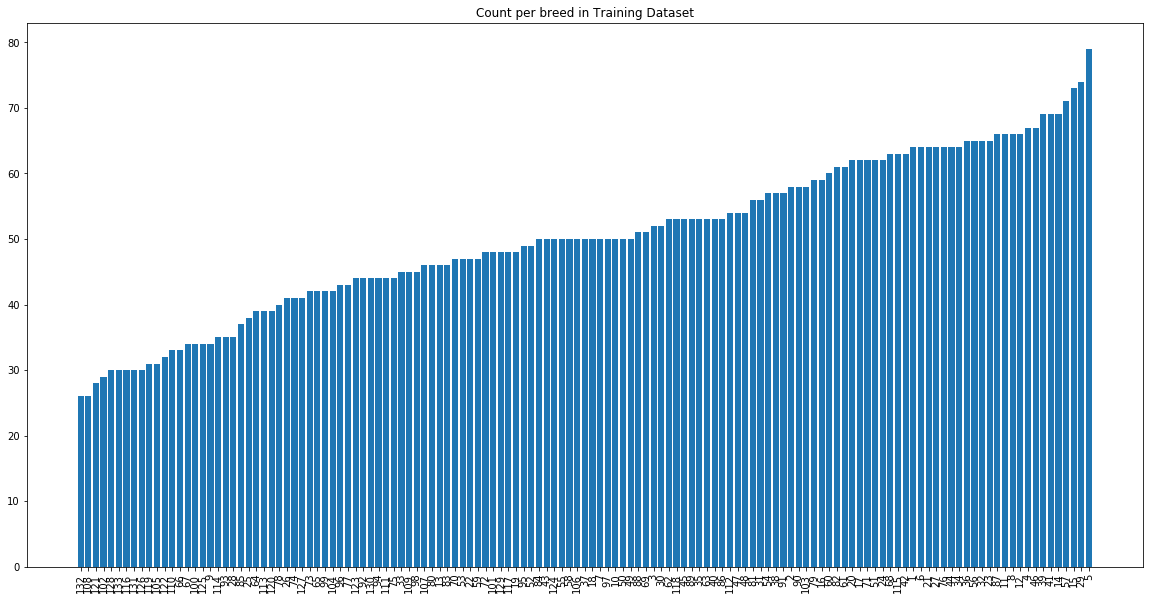

In [28]:
training_path_parts = file_parts[file_parts['6']=='train']
count_per_breed = get_count_by_breed(training_path_parts)
plot_count_by_breed(count_per_breed,"Count per breed in Training Dataset")

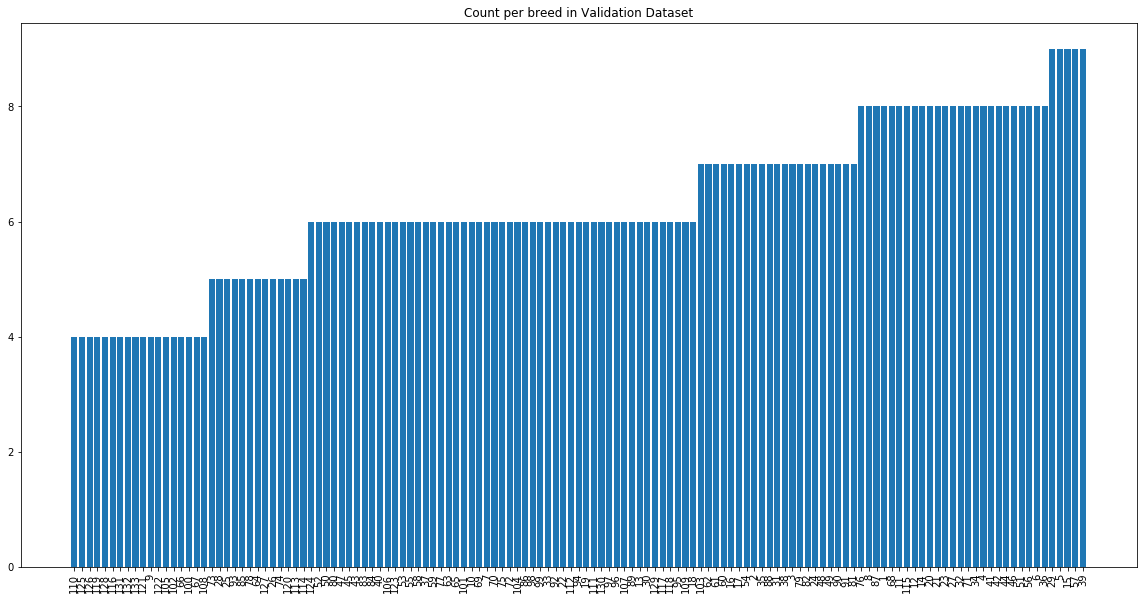

In [30]:
valid_path_parts = file_parts[file_parts['6']=='valid']
count_per_breed = get_count_by_breed(valid_path_parts)
plot_count_by_breed(count_per_breed,"Count per breed in Validation Dataset")

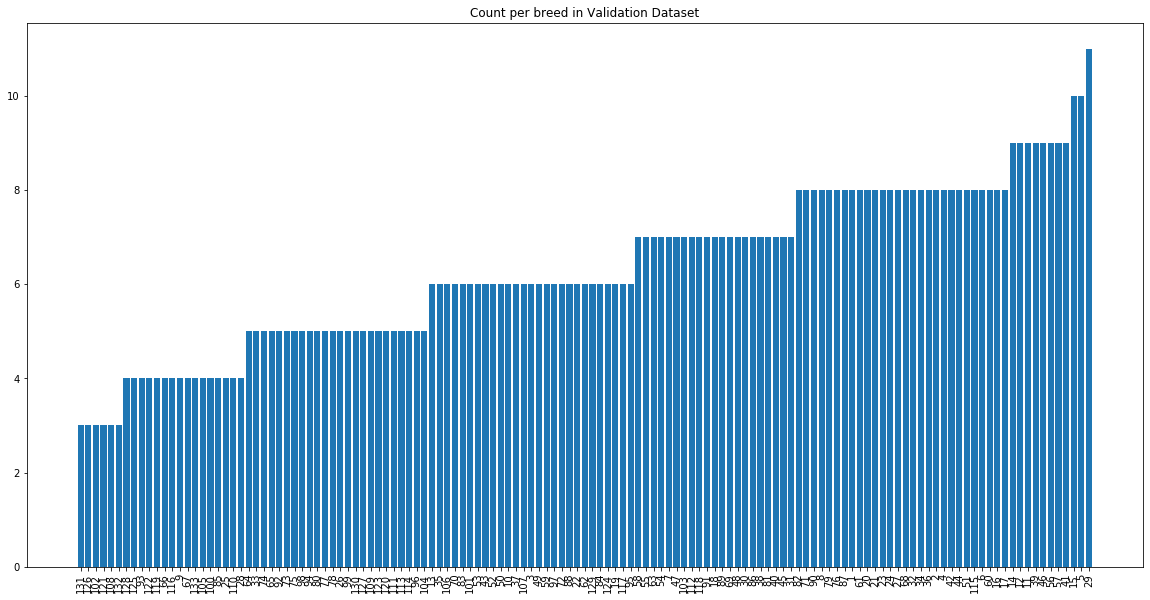

In [31]:
test_path_parts = file_parts[file_parts['6']=='test']
count_per_breed = get_count_by_breed(test_path_parts)
plot_count_by_breed(count_per_breed,"Count per breed in Validation Dataset")

As per the distribution charts above, there is clearly a considerable variance between the training data for the 133 dog breeds. This skewedness can potentially impact our accuracy performance metrics. However, for the sake of simplicity, we will stick to the accuracy metric to evaluate the final model.

## 2.4 - Algorithms and Techniques

In order to build a robust classifier, we need to rely on the following specifications when we build the model:
  - A Stocastic Gradient Decent Optimizer
  - A Cross Entropy Loss function that will be used to optimize the model
  - A pre-trained VGG16 Deep Neural Network for the initial feature recognition from the input images. This VGG16 network will not be trained with the rest of the model.
  - Additional layers on top of the pretrained VGG16 network to be trained of the recognition of the the 133 dog breeds at hand.
  - The use of ReLU activation functions in order to combat the problem of vanishing gradients.
  - Dropout layers in order to reduce the risk of overfitting.

## 2.5 - Benchmark Model

The target trained model will be benchmarked against a similar, yet simplified, model. As our traget model will involve additional layers on top of the VGG16 pretrained Network that will include multiple layers of Linear, ReLU, and, Dropout functions, the benchmark model will include a single Linear layer followed by a logsoftmax output as shown below. It's important to keep in mind that the benchmark model will be trained too till it cannot improved any further.

![alt text](./assets/figure1.png)

# 3 - Implementation

## 3.1 - Data Loading and Preprocessing

As pre-requsite to training the model, the data need to be loaded, normalized, and augmented. Accordingly, the data will be augmented first by introducing random rotations, random resizing and cropping to the desired input size, random flipped across the horizonal axis. After that all pixle RGB values will be Normalized to a pre-specified mean and standard deviation.

It's important to note that the augmentations introduced here are only necessary for the training dataset. The validation and testing datasets don't need anything more than resizing, cropping, and normalization.

Due to the big size of our dataset, we will not be able to fit it in the RAM. Accordingly, batch loader need to be defined in order to load the data in steps. The batch size to be used here is 64 images at a time.

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
                                        transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])
test_transforms = transforms.Compose([
                                        transforms.Resize(266),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=test_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64)

We also need to load the mapping of the 133 breads to the breed names stored in a json file as shown below.

In [0]:
with open(root_path+'/dog_breed_to_number_dictionary.json', 'r') as f:
    cat_to_name = json.load(f)

In [34]:
print(cat_to_name)

{'83': 'Ibizan_hound', '74': 'Giant_schnauzer', '40': 'Bulldog', '99': 'Lhasa_apso', '94': 'Komondor', '116': 'Parson_russell_terrier', '5': 'Alaskan_malamute', '11': 'Australian_cattle_dog', '105': 'Neapolitan_mastiff', '56': 'Dachshund', '42': 'Cairn_terrier', '30': 'Border_terrier', '84': 'Icelandic_sheepdog', '71': 'German_shepherd_dog', '31': 'Borzoi', '66': 'Field_spaniel', '21': 'Belgian_sheepdog', '111': 'Norwich_terrier', '98': 'Leonberger', '34': 'Boxer', '130': 'Welsh_springer_spaniel', '80': 'Greater_swiss_mountain_dog', '76': 'Golden_retriever', '27': 'Bloodhound', '95': 'Kuvasz', '125': 'Portuguese_water_dog', '69': 'French_bulldog', '93': 'Kerry_blue_terrier', '7': 'American_foxhound', '117': 'Pekingese', '16': 'Beagle', '88': 'Irish_water_spaniel', '73': 'German_wirehaired_pointer', '70': 'German_pinscher', '77': 'Gordon_setter', '96': 'Labrador_retriever', '82': 'Havanese', '29': 'Border_collie', '78': 'Great_dane', '89': 'Irish_wolfhound', '58': 'Dandie_dinmont_terrie

## 3.2 - Define Model Building Functions

In [0]:
def set_optimizer(model,learning_rate):
    optimizer = optim.SGD(model.classifier.parameters(),lr=learning_rate)
    return optimizer

In [0]:
def set_criterion():
    return nn.CrossEntropyLoss()

In [0]:
def get_accuracy(logps,labels):
    temp_logps = logps
    temp_labels = labels
    ps = torch.exp(logps)
    top_p,top_class = ps.topk(1,dim=1)
    equals = top_class == labels.view(*top_class.shape)
    batch_accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return batch_accuracy

In [0]:
def run_testing(model,criterion,device,validloader,test_type,validation_losses,validation_accuracies):
    model.eval()
    test_loss_aggregate = 0
    accuracy_aggregate = 0

    with torch.no_grad():
        for inputs,labels in validloader:
            inputs,labels = inputs.to(device),labels.to(device)
            logps = model(inputs)
            loss = criterion(logps,labels)
            test_loss_aggregate += loss.item() * inputs.size(0)
            accuracy_aggregate += get_accuracy(logps=logps,labels=labels) * inputs.size(0)
    
    validation_loss = test_loss_aggregate/len(validloader.dataset)
    validation_accuracy = accuracy_aggregate/len(validloader.dataset)

    if validation_losses != None: validation_losses.append(validation_loss)
    if validation_accuracies!= None: validation_accuracies.append(validation_accuracy)

    print(test_type+f" Loss: {validation_loss:.3f}")
    print(test_type+f" Accuracy: {validation_accuracy:.3f}")
        

In [0]:
def run_training(model,optimizer,criterion,device,trainloader,train_losses):
    # train by batch
    model.train()
    train_loss_aggregate = 0

    for inputs,labels in trainloader:
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        logps = model(inputs)
        loss = criterion(logps,labels)
        loss.backward()
        optimizer.step()
        train_loss_aggregate += loss.item() * inputs.size(0)

    train_loss = train_loss_aggregate/len(trainloader.dataset)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.3f}")

In [0]:
def run_epoch(model,optimizer,criterion,device,trainloader,validloader,train_losses,validation_losses,validation_accuracies,save_path):
    
    run_training(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                device=device,
                trainloader=trainloader,
                train_losses=train_losses
                )
    run_testing(
                model=model,
                criterion=criterion,
                device=device,
                validloader=validloader,
                test_type="Validation",
                validation_losses=validation_losses,
                validation_accuracies=validation_accuracies
                )

In [0]:
def set_device(mode_of_operation):
    # set the default device - initially only CPU
    device = "cpu"
    if torch.cuda.is_available() and mode_of_operation == "heavy": device = "cuda:0"
    else: device = "cpu"
    return device
    

In [0]:
def train_model(model,mode_of_operation,epochs,save_path):
    device = set_device(mode_of_operation)
    model.to(device)
    optimizer = set_optimizer(model,learning_rate = 0.005)
    criterion = set_criterion()
    
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    minimum_valid_loss = np.Inf # start by assigning the minimum validation loss an infinite value

    for epoch in range(epochs):
      print("Epoch {}/{}".format(epoch+1,epochs))
      run_epoch(
                  model=model,
                  optimizer=optimizer,
                  criterion=criterion,
                  device=device,
                  trainloader=train_loader,
                  validloader=valid_loader,
                  train_losses=train_losses,
                  validation_losses=validation_losses,
                  validation_accuracies=validation_accuracies,
                  save_path=save_path
              )
      
      if validation_losses[-1]<=minimum_valid_loss:
          print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                  format(minimum_valid_loss, validation_losses[-1]))
          torch.save(model.state_dict(), save_path)
          minimum_valid_loss = validation_losses[-1]

    return model,train_losses,validation_losses,validation_accuracies

## 3.3 - Define Model Functions for Benchmark and Target Models

In [0]:
def set_benchmark_model():
    # create a dense net model
    model = models.vgg16(pretrained = True)

    # switch off the gradients of the convolutional feature recognition layer
    for param in model.parameters():
        param.requires_grad = False # this will stop training for the vgg16 pre-trained network
    
    model.classifier = nn.Sequential(
        nn.Linear(25088,133),
        nn.LogSoftmax(dim=1)
    )

    return model

In [0]:
def set_target_model():
    # create a dense net model
    model = models.vgg16(pretrained = True)

    # switch off the gradients of the convolutional feature recognition layer
    for param in model.parameters():
        param.requires_grad = False # this will stop training for the vgg16 pre-trained network
    
    
    # replace the classifier layer
    # parameters here require gradient by default
    model.classifier = nn.Sequential(
        nn.Linear(25088,750),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(750,300),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(300,133),
        nn.LogSoftmax(dim=1)
    )
    return model

## 3.4 - Building and Training the Models

In [45]:
benchmark_model = set_benchmark_model()
print(benchmark_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
benchmark_model, bench_train_losses, bench_validation_losses, bench_validation_accuracies = train_model(
    benchmark_model,
    mode_of_operation='heavy',
    epochs=40,
    save_path='gdrive/My Drive/Colab Notebooks/Dog_Breed_Classifier_with_Pytorch/benchmark_model.pt')

Epoch 1/40
Training Loss: 2.932
Validation Loss: 1.398
Validation Accuracy: 0.610
Validation loss decreased (inf --> 1.397505).    Saving model...
Epoch 2/40
Training Loss: 1.742
Validation Loss: 1.045
Validation Accuracy: 0.693
Validation loss decreased (1.397505 --> 1.044554).    Saving model...
Epoch 3/40
Training Loss: 1.412
Validation Loss: 0.851
Validation Accuracy: 0.760
Validation loss decreased (1.044554 --> 0.851070).    Saving model...
Epoch 4/40
Training Loss: 1.253
Validation Loss: 0.795
Validation Accuracy: 0.778
Validation loss decreased (0.851070 --> 0.794964).    Saving model...
Epoch 5/40
Training Loss: 1.171
Validation Loss: 0.720
Validation Accuracy: 0.813
Validation loss decreased (0.794964 --> 0.720128).    Saving model...
Epoch 6/40
Training Loss: 1.083
Validation Loss: 0.675
Validation Accuracy: 0.805
Validation loss decreased (0.720128 --> 0.674745).    Saving model...
Epoch 7/40
Training Loss: 0.987
Validation Loss: 0.668
Validation Accuracy: 0.812
Validation 

In [46]:
target_model = set_target_model()
print(target_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
target_model, target_train_losses, target_validation_losses, target_validation_accuracies = train_model(
    target_model,mode_of_operation='heavy',
    epochs=80,
    save_path='gdrive/My Drive/Colab Notebooks/Dog_Breed_Classifier_with_Pytorch/target_model.pt')


Epoch 1/80
Training Loss: 4.757
Validation Loss: 4.333
Validation Accuracy: 0.226
Validation loss decreased (inf --> 4.332769).    Saving model...
Epoch 2/80
Training Loss: 4.276
Validation Loss: 3.281
Validation Accuracy: 0.375
Validation loss decreased (4.332769 --> 3.281263).    Saving model...
Epoch 3/80
Training Loss: 3.555
Validation Loss: 2.238
Validation Accuracy: 0.527
Validation loss decreased (3.281263 --> 2.237818).    Saving model...
Epoch 4/80
Training Loss: 2.902
Validation Loss: 1.566
Validation Accuracy: 0.626
Validation loss decreased (2.237818 --> 1.565798).    Saving model...
Epoch 5/80
Training Loss: 2.483
Validation Loss: 1.237
Validation Accuracy: 0.671
Validation loss decreased (1.565798 --> 1.237374).    Saving model...
Epoch 6/80
Training Loss: 2.160
Validation Loss: 0.996
Validation Accuracy: 0.723
Validation loss decreased (1.237374 --> 0.995706).    Saving model...
Epoch 7/80
Training Loss: 1.951
Validation Loss: 0.870
Validation Accuracy: 0.753
Validation 

# 4 - Result Analysis

## 4.1 - Compare the Benchmark and Target Models

In [0]:
def view_learning_curves(train_losses,validation_losses,validation_accuracies):
    %matplotlib inline
    plt.plot(train_losses,label="Train Loss")
    plt.plot(validation_losses,label="Validation Loss")
    plt.plot(validation_accuracies,label="Validation Accuracy")
    plt.legend(frameon=False) 

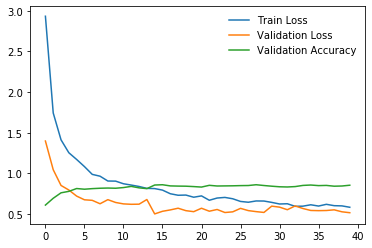

In [0]:
view_learning_curves(bench_train_losses,bench_validation_losses,bench_validation_accuracies)

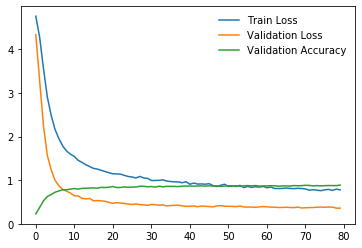

In [0]:
view_learning_curves(target_train_losses,target_validation_losses,target_validation_accuracies)

As per the scree plot above, the validation loss for the target model is way more stable in it's decent. The model can potentially be improved if trained for more epochs. Moreover, we could also try adding more layers to our model, or expand the layer sizes in order to try and improve its performance.

## 4.2 - Loading the Optimized Models

Once we are done with training, we can load the optimized models for testing.

In [0]:
test_criterion = set_criterion()
test_device = set_device('heavy')

In [48]:
benchmark_model.load_state_dict(torch.load('gdrive/My Drive/Colab Notebooks/Dog_Breed_Classifier_with_Pytorch/benchmark_model.pt'))
benchmark_model.to(test_device)

target_model.load_state_dict(torch.load('gdrive/My Drive/Colab Notebooks/Dog_Breed_Classifier_with_Pytorch/target_model.pt'))
target_model.to(test_device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 4.3 - Testing the Models

In [0]:
run_testing(
                model=benchmark_model,
                criterion=test_criterion,
                device=test_device,
                validloader=test_loader,
                validation_losses = None,
                validation_accuracies = None,
                test_type = "Test"
            )

Test Loss: 0.626
Test Accuracy: 0.831


In [0]:
run_testing(
                model=target_model,
                criterion=test_criterion,
                device=test_device,
                validloader=test_loader,
                validation_losses = None,
                validation_accuracies = None,
                test_type = "Test"
            )

Test Loss: 0.436
Test Accuracy: 0.866


We can see a considerable improvement in the target model over the benchmark model.

| Model | Cross Entropy Loss | Accuracy   | CrossEntropyLoss difference (compared to benchmark) | Accuracy difference (compared to benchmark) |
|------|------|------|------|------|
|   Benchmark Model  | 0.626 | 83.1% | 0% | 0% |
| Target Model | 0.436 | 86.6% | -30.3% | +4.2% |

## 4.4 - Test Demo

In [0]:
def invert_class_to_idx(class_to_idx):
        return dict(map(reversed, class_to_idx.items()))

In [0]:
target_model.class_to_idx = train_data.class_to_idx
target_model.idx_to_class = invert_class_to_idx(train_data.class_to_idx)

### Image Preprocessing

In [0]:
def resize_image(image,short_dimension=256):
    target_ratio = 1
    if image.width <= image.height:
        target_ratio = short_dimension/image.width
    else:
        target_ratio = short_dimension/image.height
    return image.resize([int(image.width*target_ratio),int(image.height*target_ratio)])

In [0]:
def crop_center_image(image,width,height):
    w = image.width
    h = image.height

    L = (w-width)/2
    T = (h-height)/2
    R = (w+width)/2
    B = (h+height)/2
    return image.crop((L,T,R,B))

In [0]:
def normalize_color_channels(image,means,deviations):
    image = image/255
    image = (image-means)/deviations
    return image
    

In [0]:
def process_image(image):
    image = resize_image(image,256)
    image = crop_center_image(image,224,224)
    np_image = np.array(image)
    np_image = normalize_color_channels(np_image,[0.485,0.456,0.406],[0.229,0.224,0.225])
    return np_image.transpose(2,0,1)

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

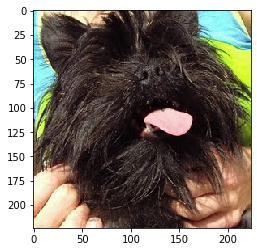

In [56]:
test_image_path = test_dir+"/1/Affenpinscher_00003.jpg"
test_image = Image.open(test_image_path)
processed_image = process_image(test_image)
processed_image = torch.from_numpy(processed_image)
imshow(processed_image)

### Class Prediction

In [0]:
def predict(image_path, model, topk=5):
    test_image = Image.open(image_path)
    processed_image = process_image(test_image)
    processed_image = torch.from_numpy(processed_image)
    processed_image = processed_image.unsqueeze(0)
    model.eval()
    model.cpu()
    model.double()
    logps = model(processed_image)
    ps = torch.exp(logps)
    top_p,top_classes = ps.topk(topk,dim=1)
    top_p = top_p.squeeze(0).tolist()
    top_classes = top_classes.squeeze(0).tolist()
    top_classes = list(map(model.idx_to_class.get, top_classes))
    
    return top_p,top_classes

In [58]:
predict(test_image_path, target_model)

([0.9134444935633494,
  0.07711501661925131,
  0.008513747730917889,
  0.00024974756949878605,
  0.00013117790749789008],
 ['1', '38', '42', '33', '99'])

### Sanity Checking

In [0]:
def plot_image_and_probabilities(image,actual_class,model,top_classes,top_probabilities,cat_2_name):
    
    classes_labels = list(map(cat_2_name.get, top_classes))
    
    fig = plt.figure(figsize=(10,10))
    image_section = plt.subplot2grid((20,10), (0,0), colspan=10, rowspan=10)
    probabilities_section = plt.subplot2grid((20,10), (11,0), colspan=10, rowspan=10)
    
    image_section.set_title(actual_class)
    image_section.axis('off')
    image_section.imshow(image)
    

    probabilities_section.set_yticks(np.arange(5))
    probabilities_section.set_yticklabels(classes_labels)
    probabilities_section.invert_yaxis()
    probabilities_section.set_xlabel('Probability')
    probabilities_section.barh(np.arange(5), top_probabilities, xerr=0, align='center', color='blue')

    plt.show()

In [0]:
def run_a_random_test():
    random_category = np.random.randint(1,102)
    path = test_dir+"/"+str(random_category)
    random_file = random.choice(os.listdir(path))
    
    actual_class = cat_to_name[str(random_category)]
    
    test_image_path = path+"/"+random_file
    image = Image.open(test_image_path)
    
    
    top_probabilities, top_classes = predict(test_image_path, target_model)
    plot_image_and_probabilities(image,actual_class,target_model,top_classes,top_probabilities,cat_to_name)
    
    prediction_class_num = top_classes[0]
    prediction_class = cat_to_name[str(prediction_class_num)]
    
    print(f'Actual Class: {actual_class}')
    print(f'Prediction Class: {prediction_class}')
    print(f'Is Prediction Correct?: {actual_class == prediction_class}')


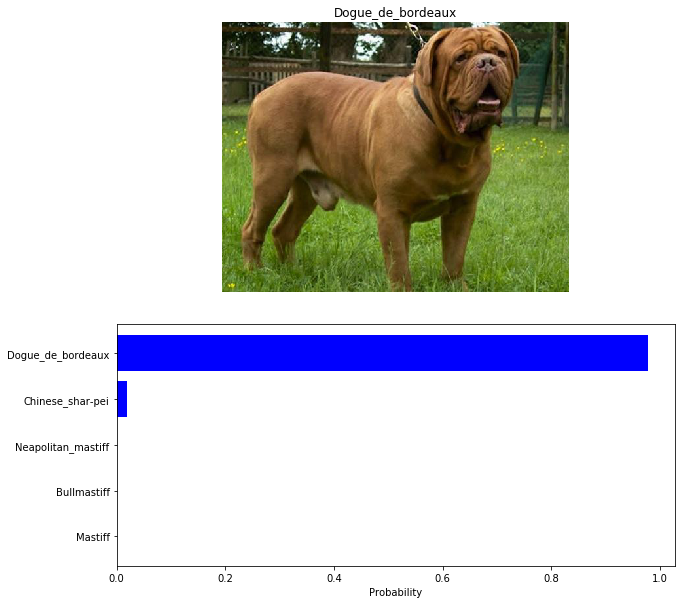

Actual Class: Dogue_de_bordeaux
Prediction Class: Dogue_de_bordeaux
Is Prediction Correct?: True


In [61]:
run_a_random_test()

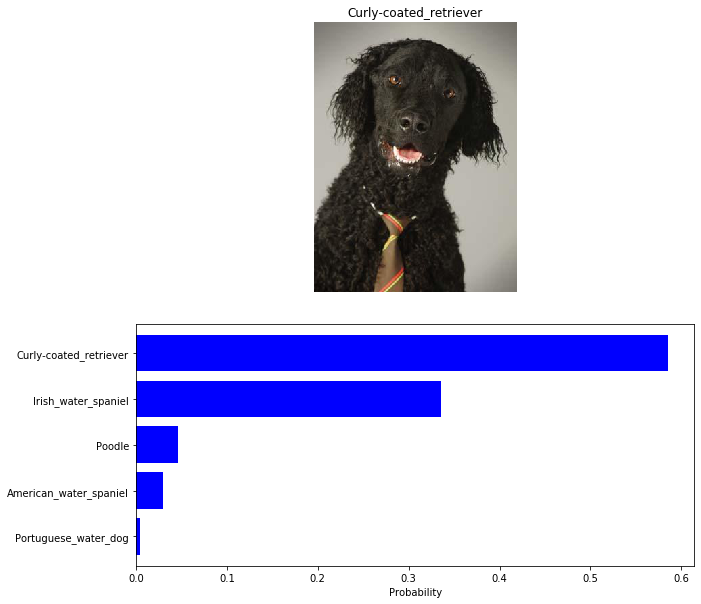

Actual Class: Curly-coated_retriever
Prediction Class: Curly-coated_retriever
Is Prediction Correct?: True


In [62]:
run_a_random_test()

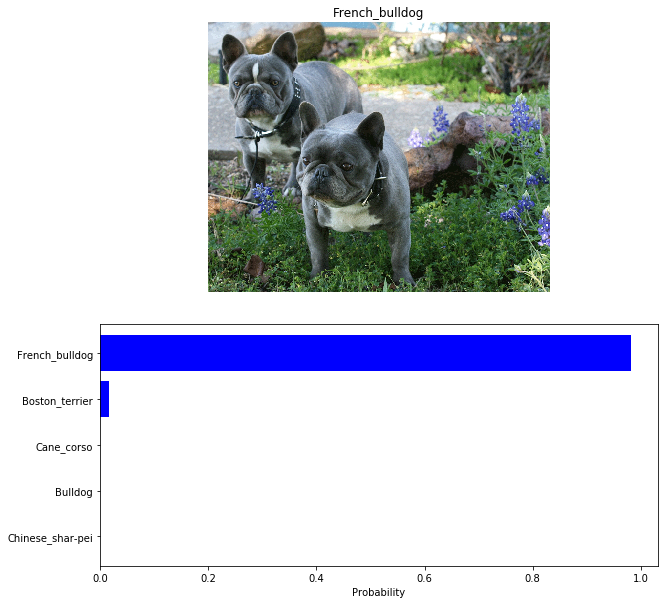

Actual Class: French_bulldog
Prediction Class: French_bulldog
Is Prediction Correct?: True


In [63]:
run_a_random_test()

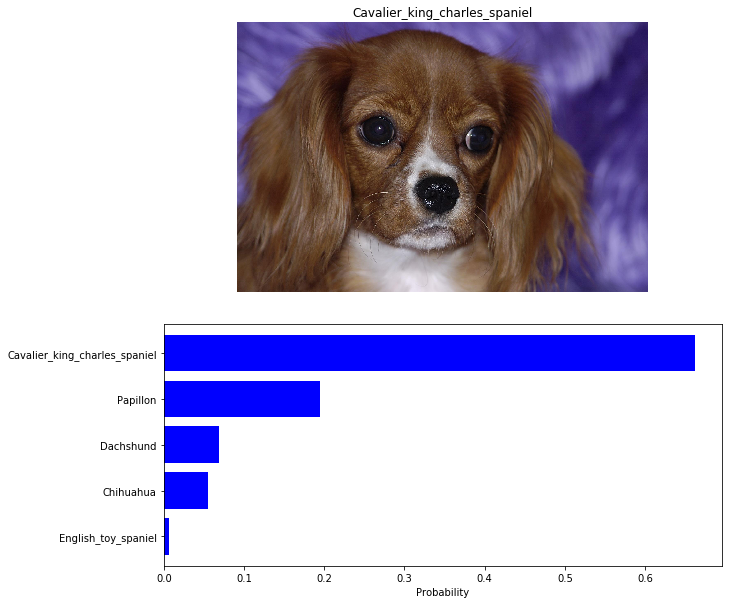

Actual Class: Cavalier_king_charles_spaniel
Prediction Class: Cavalier_king_charles_spaniel
Is Prediction Correct?: True


In [64]:
run_a_random_test()

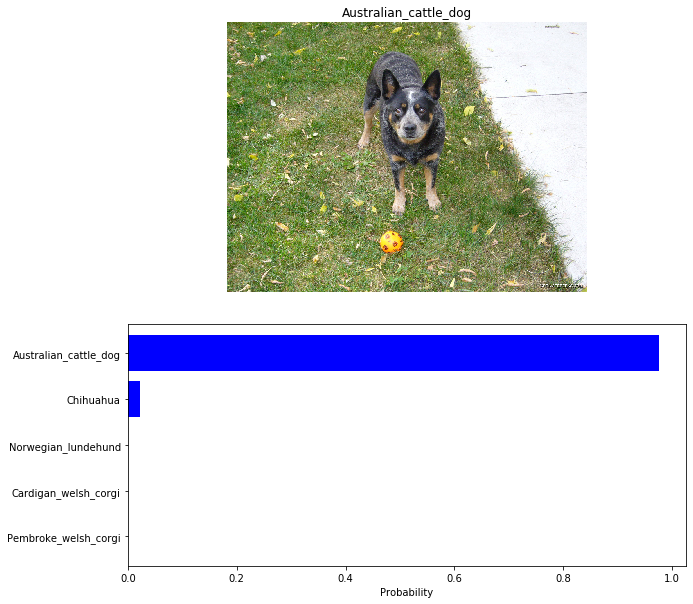

Actual Class: Australian_cattle_dog
Prediction Class: Australian_cattle_dog
Is Prediction Correct?: True


In [65]:
run_a_random_test()

# 5 - Conclusions

- We have successfully built and trained a Deep Neural Net model based on the VGG16 pre-trained network to predict the breed of a dog by image input for 133 dog breeds.
- The model can predict the breed of 133 dogs with 86.6% accuracy.
- The trained model has achieved an increase in prediction accuracy of 4.2% over the benchmark model on the testing dataset.
- The trained model has achieved a reduction of Cross Entropy Loss of 30.3% below the benchmark model on the testing dataset.